**Bibliotecas**

In [ ]:
#Coletados Comentários
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Transformar a coluna de versões para fazer filtro melhores
from packaging.version import parse

#Para realizar paralelismo
import swifter

#Tratamentos
import re
import emoji
import nltk
from nltk.corpus import stopwords
import stanza

#Sentimentos dos Comentários
from pysentimiento import create_analyzer

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [17]:
#Download de pacotes
nltk.download("stopwords")
stanza.download('pt')

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-10 16:24:06 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-10 16:24:06 INFO: Downloading default packages for language: pt (Portuguese) ...
2025-06-10 16:24:07 INFO: File exists: C:\Users\Computador\stanza_resources\pt\default.zip
2025-06-10 16:24:10 INFO: Finished downloading models and saved to C:\Users\Computador\stanza_resources
2025-06-10 16:24:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-10 16:24:10 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-10 16:24:11 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package         |
-------------------------------
|

**Funções**

In [18]:
stopwords_pt = set(stopwords.words("portuguese"))

In [19]:
def tratamento_de_texto(texto):
    texto = emoji.demojize(texto, language="pt")
    texto = texto.lower()
    texto = re.sub(r'\b(vivo|claro|tim)\b', 'operadora', texto)
    texto = re.sub(r'(:[^:\s]+:)', r' \1 ', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-zá-úà-üç\s]", "", texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    doc = nlp(texto)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stopwords_pt and len(word.lemma) > 2]
    
    return " ".join(lemmas)

In [56]:
temas_manuais = {
    "Operadora": [r"operadora"],
    "App": [r"\bapp\b", r"\baplicativo\b"],
    "Login": [r"logar", r"\blogin\b", r"acessar", r"entrar", r"cadastrar", r"cadastro"],
    "Atualização": [r"atualização", r"atualizei", r"versão", r"nova versão", r"última atualização"],
    "Atendimento": [r"atendimento", r"chat", r"suporte", r"atendente", r"fale conosco", r"não responde", r"reclame"],
    "Usabilidade": [r"interface", r"usabilidade", r"navegação", r"botão", r"menu", r"layout", r"tela", r"confuso", r"difícil"],
    "Conta": [r"fatura", r"boleto", r"cobrança", r"pagamento", r"conta", r"valor indevido", r"preço errado"],
    "Plano": [r"serviço", r"plano", r"contrato", r"assinatura", r"benefício", r"pacote"],
    "Internet": [r"internet", r"sinal", r"conexão", r"velocidade", r"3g", r"4g", r"5g", r"wi[- ]?fi", r"queda"],
    "Recarga": [r"recarga", r"créditos", r"saldo"],
    "Benefícios": [r"promoção", r"desconto", r"benefício", r"cashback", r"oferta"],
    "Desempenho": [r"bug", r"erro", r"trava", r"lento", r"crash", r"problema", r"instabilidade"],
    "Notificações": [r"notificação", r"alerta", r"mensagem push", r"aviso", r"push", r"mensagem", r"sms"]
}


In [61]:
def classificar_tema(texto, temas_dict):
    texto = texto.lower()
    temas_encontrados = []
    for tema, padroes in temas_dict.items():
        for padrao in padroes:
            if re.search(padrao, texto):
                temas_encontrados.append(tema)
                break  # Evita múltiplas adições do mesmo tema
    return temas_encontrados  # Sem categoria 'Outro'

In [22]:
analyzers = {
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


# Extração de Comentários

In [23]:
qtd_comentarios = 15000

dados_android = []

apps = {
    "Claro": "com.nvt.cs",
    "TIM": "br.com.timbrasil.meutim",
    "Vivo": "br.com.vivo"
}

In [24]:
for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

In [25]:
comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])
comentarios_android.to_csv("comentarios.csv", index=False)
comentarios_android.shape

(45000, 5)

# Análise de Sentimento

## Análises

In [26]:
comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(tratamento_de_texto)

Pandas Apply: 100%|██████████| 45000/45000 [1:12:54<00:00, 10.29it/s]


In [27]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|██████████| 45000/45000 [51:36<00:00, 14.53it/s]  


In [28]:
df.to_csv("comentarios_processados.csv", index=False)

In [29]:
print("Data mínima da Claro: ", df[df['app']=='Claro']['date'].min())
print("Data mínima da TIM: ", df[df['app']=='TIM']['date'].min())
print("Data mínima da Vivo: ", df[df['app']=='Claro']['date'].min())
print("Data máxima da Claro: ", df[df['app']=='Claro']['date'].max())
print("Data máxima da TIM: ", df[df['app']=='TIM']['date'].max())
print("Data máxima da Vivo: ", df[df['app']=='Claro']['date'].max())

Data mínima da Claro:  2024-12-11 11:32:18
Data mínima da TIM:  2024-12-12 11:37:05
Data mínima da Vivo:  2024-12-11 11:32:18
Data máxima da Claro:  2025-06-09 16:14:31
Data máxima da TIM:  2025-06-09 16:05:37
Data máxima da Vivo:  2025-06-09 16:14:31


### Notas

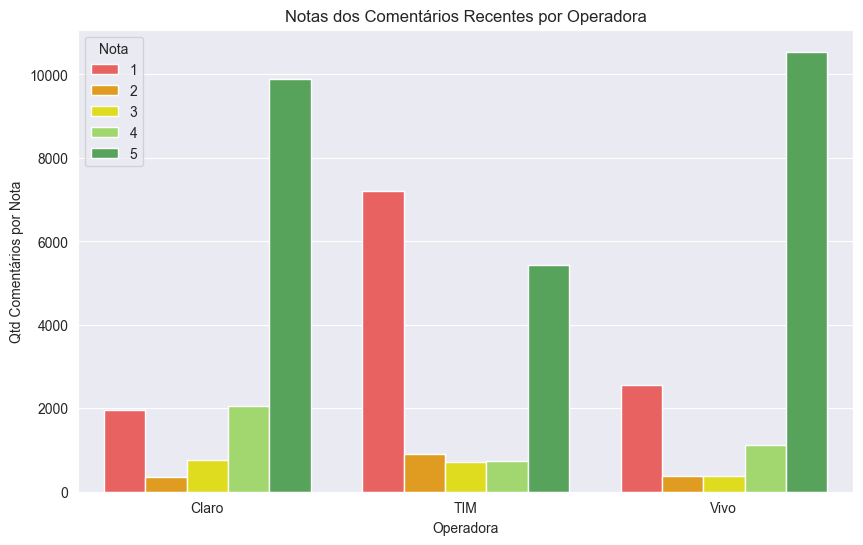

In [30]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plotar gráfico com hue simplificado
sns.countplot(
    data=df,
    x='app',
    hue='score',
    palette={1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'},
    hue_order=[1, 2, 3, 4, 5]
)

plt.title("Notas dos Comentários Recentes por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Qtd Comentários por Nota")
plt.legend(title="Nota")

plt.show()

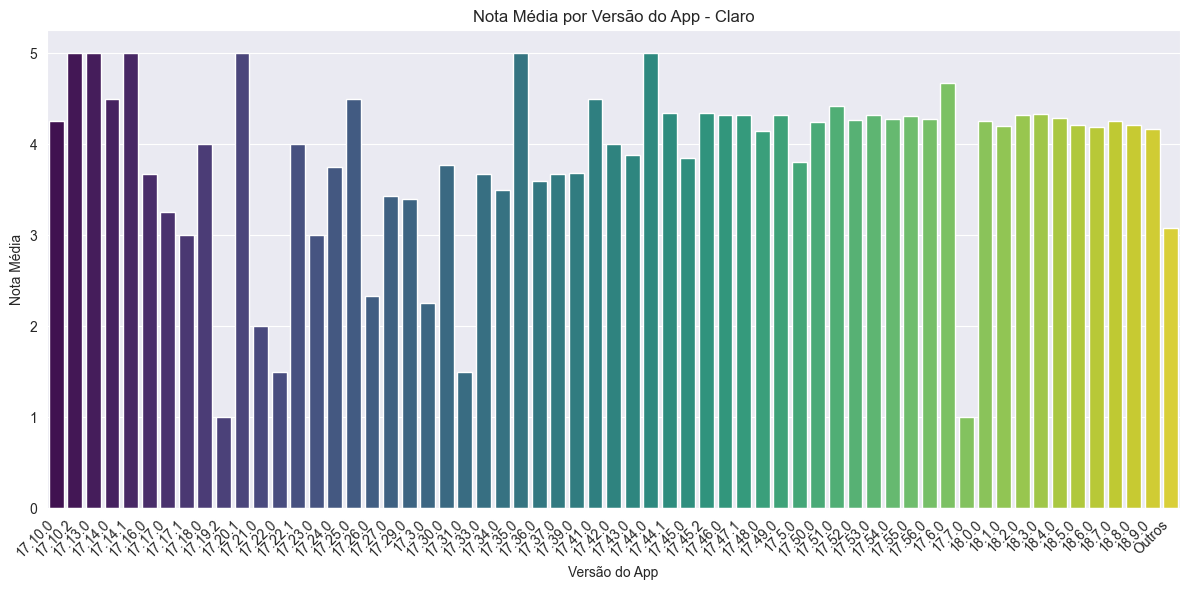

In [31]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Claro')
plt.tight_layout()
plt.show()


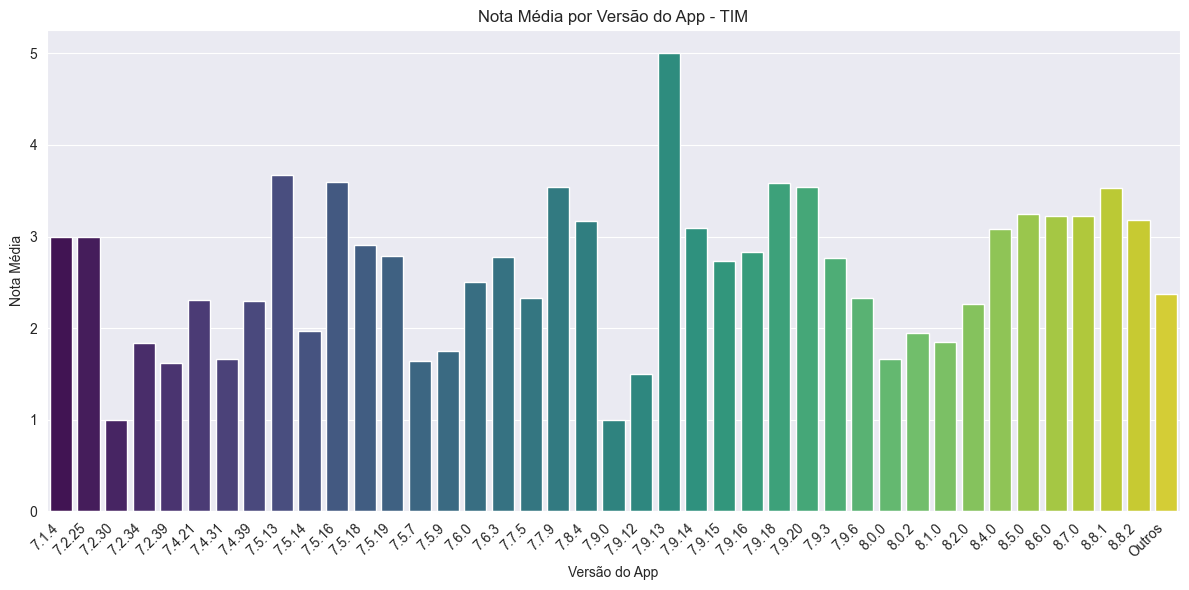

In [32]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - TIM')
plt.tight_layout()
plt.show()

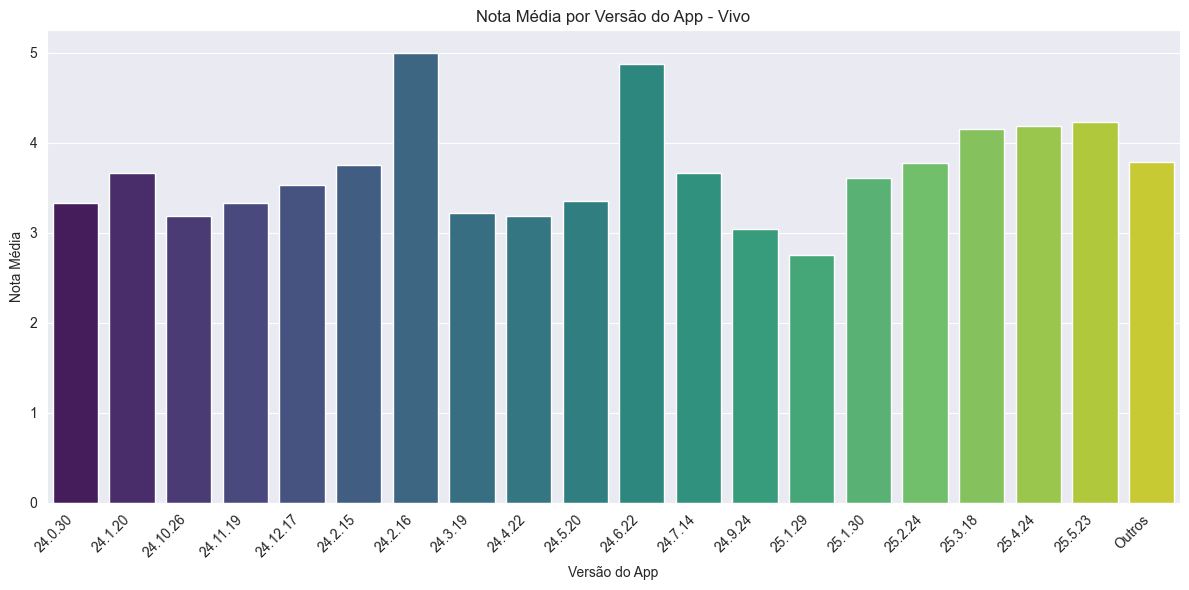

In [33]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Vivo')
plt.tight_layout()
plt.show()

### Sentimentos por Versão

#### Claro

In [34]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,17.10.0,17.10.2,17.13.0,17.14.0,17.14.1,17.16.0,17.17.0,17.17.1,17.18.0,17.19.2,17.20.1,17.21.0,17.22.0,17.22.1,17.23.0,17.24.0,17.25.0,17.26.0,17.27.0,17.29.0,17.3.0,17.30.0,17.31.0,17.33.0,17.34.0,17.35.0,17.36.0,17.37.0,17.39.0,17.41.0,17.42.0,17.43.0,17.44.0,17.44.1,17.45.0,17.45.2,17.46.0,17.47.1,17.48.0,17.49.0,17.5.0,17.50.0,17.51.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,17.6.0,17.7.0,18.0.0,18.1.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,18.9.0,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,3.0,2.0,0.0,2.0,2.0,0.0,2.0,7.0,6.0,0.0,3.0,9.0,0.0,81.0,11.0,40.0,43.0,137.0,189.0,105.0,1.0,59.0,19.0,61.0,79.0,188.0,59.0,138.0,0.0,1.0,86.0,24.0,41.0,75.0,124.0,121.0,71.0,41.0,71.0,3.0,400.0
NEU,2.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,0.0,2.0,0.0,3.0,2.0,2.0,3.0,3.0,0.0,8.0,2.0,7.0,1.0,1.0,2.0,9.0,11.0,0.0,7.0,23.0,2.0,332.0,17.0,173.0,192.0,518.0,522.0,419.0,3.0,209.0,88.0,226.0,325.0,637.0,176.0,432.0,2.0,0.0,325.0,74.0,171.0,275.0,460.0,365.0,269.0,134.0,315.0,18.0,456.0
POS,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,0.0,3.0,1.0,0.0,1.0,5.0,2.0,2.0,3.0,11.0,1.0,266.0,26.0,130.0,161.0,425.0,356.0,317.0,1.0,169.0,71.0,182.0,193.0,495.0,138.0,367.0,1.0,0.0,237.0,48.0,114.0,206.0,348.0,298.0,178.0,95.0,189.0,9.0,254.0


In [35]:
frequencias = df[df['app'] == 'Claro']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Claro']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,17.44.1,17.45.2,17.46.0,17.47.1,17.48.0,17.49.0,17.50.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,18.0.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,
NEG,81,40,43,137,189,105,59,61,79,188,59,138,86,41,75,124,121,71,41,71,167
NEU,332,173,192,518,522,419,209,226,325,637,176,432,325,171,275,460,365,269,134,315,353
POS,266,130,161,425,356,317,169,182,193,495,138,367,237,114,206,348,298,178,95,189,234


#### TIM

In [36]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,7.1.4,7.2.25,7.2.30,7.2.34,7.2.39,7.4.21,7.4.31,7.4.39,7.5.13,7.5.14,7.5.16,7.5.18,7.5.19,7.5.7,7.5.9,7.6.0,7.6.3,7.7.5,7.7.9,7.8.4,7.9.0,7.9.12,7.9.13,7.9.14,7.9.15,7.9.16,7.9.18,7.9.20,7.9.3,7.9.6,8.0.0,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,8.8.2,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,4.0,2.0,1.0,6.0,2.0,5.0,15.0,17.0,1.0,19.0,2.0,9.0,11.0,6.0,35.0,13.0,6.0,3.0,3.0,7.0,0.0,0.0,0.0,3.0,31.0,277.0,312.0,508.0,46.0,2.0,4.0,1127.0,559.0,955.0,310.0,196.0,490.0,294.0,91.0,5.0,1277.0
NEU,3.0,1.0,0.0,6.0,5.0,6.0,5.0,6.0,3.0,13.0,1.0,9.0,12.0,3.0,12.0,6.0,12.0,1.0,6.0,13.0,1.0,2.0,0.0,5.0,31.0,316.0,501.0,784.0,40.0,0.0,2.0,512.0,250.0,641.0,281.0,224.0,681.0,332.0,186.0,5.0,898.0
POS,3.0,1.0,0.0,0.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,3.0,4.0,2.0,4.0,3.0,3.0,2.0,2.0,4.0,0.0,0.0,1.0,3.0,14.0,104.0,279.0,436.0,19.0,1.0,0.0,147.0,60.0,174.0,158.0,102.0,323.0,203.0,66.0,1.0,316.0


In [37]:
frequencias = df[df['app'] == 'TIM']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'TIM']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,7.9.16,7.9.18,7.9.20,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,Outros
sentiment_output,,,,,,,,,,,,
NEG,277,312,508,1127,559,955,310,196,490,294,91,433
NEU,316,501,784,512,250,641,281,224,681,332,186,317
POS,104,279,436,147,60,174,158,102,323,203,66,128


#### Vivo

In [38]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,24.0.30,24.1.20,24.10.26,24.11.19,24.12.17,24.2.15,24.2.16,24.3.19,24.4.22,24.5.20,24.6.22,24.7.14,24.9.24,25.1.29,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,
NEG,1.0,1.0,8.0,12.0,10.0,0.0,0.0,2.0,1.0,4.0,0.0,6.0,11.0,1.0,28.0,44.0,792.0,550.0,538.0,486.0
NEU,4.0,2.0,8.0,15.0,19.0,1.0,1.0,6.0,5.0,7.0,6.0,7.0,10.0,3.0,55.0,83.0,2483.0,1916.0,1985.0,999.0
POS,1.0,0.0,0.0,4.0,7.0,3.0,1.0,1.0,4.0,3.0,1.0,2.0,6.0,0.0,25.0,54.0,1516.0,1225.0,1317.0,587.0


In [39]:
frequencias = df[df['app'] == 'Vivo']['app_version'].value_counts()

limiar = 50
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Vivo']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,
NEG,28,44,792,550,538,116
NEU,55,83,2483,1916,1985,159
POS,25,54,1516,1225,1317,74


### Sentimentos

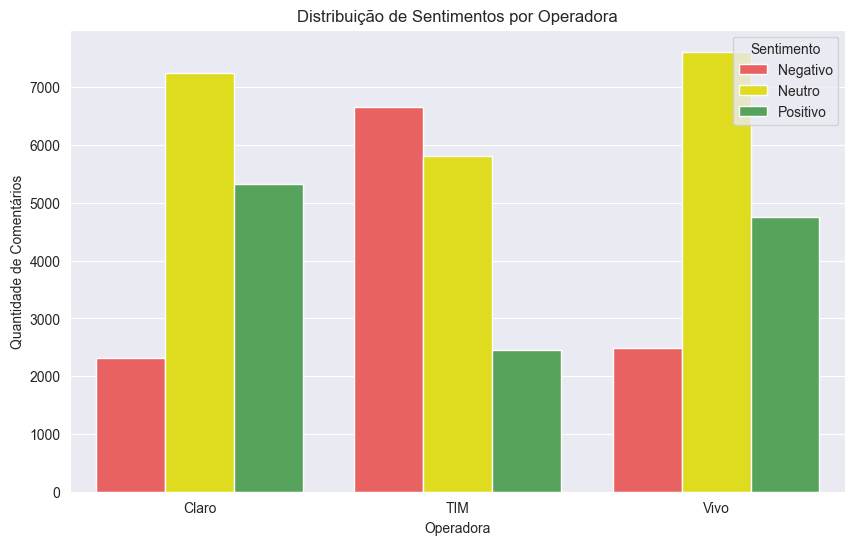

In [40]:
def map_sentiment(sent):
    if sent in ['NEG', 'negativo']:
        return 'Negativo'
    elif sent in ['NEU', 'neutro']:
        return 'Neutro'
    elif sent in ['POS', 'positivo']:
        return 'Positivo'
    else:
        return 'Outro'

df['sentimento_simplificado'] = df['sentiment_output'].apply(map_sentiment)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()


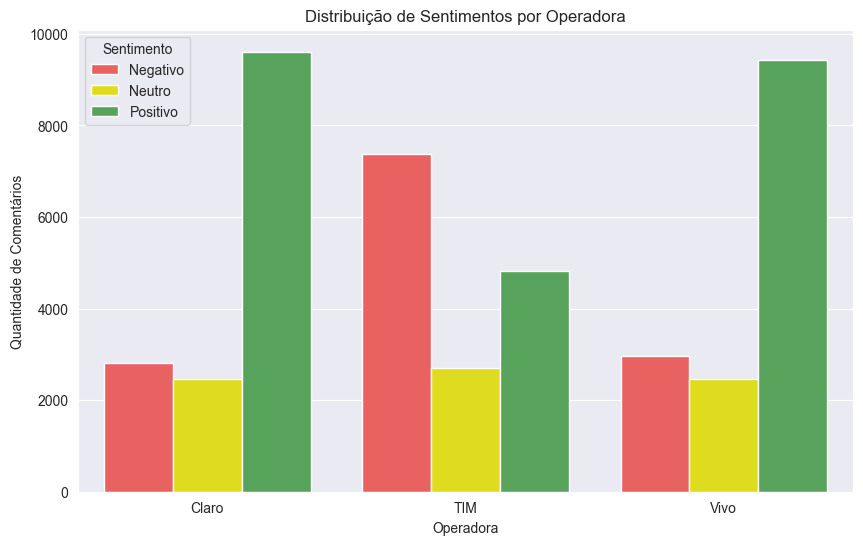

In [41]:
def map_sentiment(row, limiar_neu=0.7):
    sentiment = row.get('sentiment_output', '')
    if sentiment == 'NEG':
        return 'Negativo'
    elif sentiment == 'POS':
        return 'Positivo'
    elif sentiment == 'NEU':
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= limiar_neu:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment

df['sentimento_simplificado'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

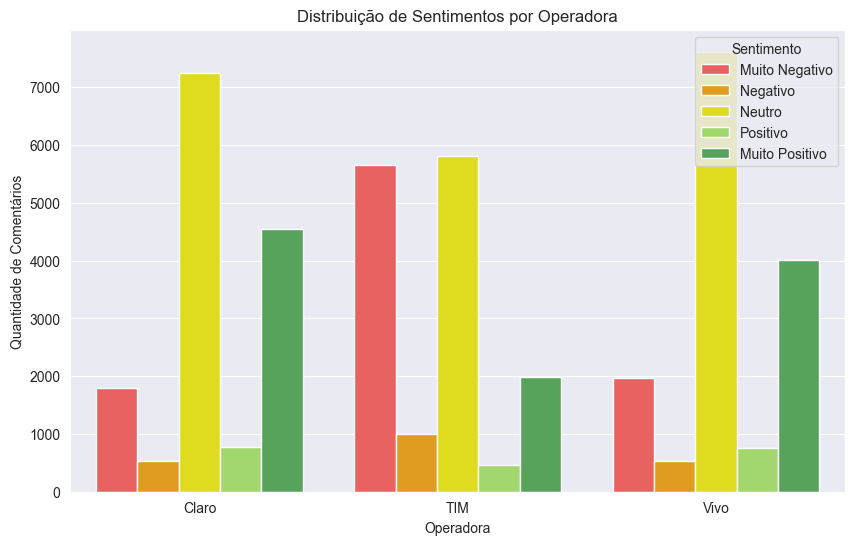

In [42]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.8:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.8:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        return "Neutro"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

In [43]:
df[(df["sentiment_output"] == "NEU") & (df["sentiment_NEU"] < 0.5)].head()

,date,score,app_version,app,content,content_proc,sentiment_output,sentiment_NEG,sentiment_NEU,sentiment_POS,emotion_alegria,emotion_tristeza,emotion_raiva,emotion_medo,emotion_surpresa,emotion_confianca,emotion_confusao,emotion_neutro,emotion_output,app_version_agrupada,sentimento_simplificado,sentimento_complexo
107,2025-06-08 10:18:20,1,18.8.0,Claro,🤬,rostocomsímbolosnabo,NEU,0.469658,0.486660,0.043682,0.011143,0.006256,0.043007,0.002886,0.003275,0.003816,0.001498,0.957762,neutro,18.8.0,Negativo,Neutro
139,2025-06-07 20:05:26,5,18.8.0,Claro,gostei,gostar,NEU,0.103688,0.450769,0.445543,0.845733,0.003938,0.036336,0.000890,0.003317,0.009860,0.001083,0.141101,alegria,18.8.0,Positivo,Neutro
276,2025-06-06 10:15:30,1,None,Claro,"ia fechar um plano pós, vendedora atendeu mal ...",fechar plano pós vendedor atender mal desistir...,NEU,0.449277,0.463483,0.087239,0.012236,0.006539,0.015041,0.001006,0.003241,0.005041,0.002441,0.987690,neutro,None,Negativo,Neutro
330,2025-06-05 18:03:24,4,18.8.0,Claro,estou gostando,gostar,NEU,0.103688,0.450769,0.445543,0.845733,0.003938,0.036336,0.000890,0.003317,0.009860,0.001083,0.141101,alegria,18.8.0,Positivo,Neutro
332,2025-06-05 17:22:28,2,18.8.0,Claro,Anúncios demais,anúncio demais,NEU,0.344070,0.409144,0.246785,0.009360,0.001540,0.007225,0.000583,0.003101,0.002983,0.001338,0.992796,neutro,18.8.0,Negativo,Neutro


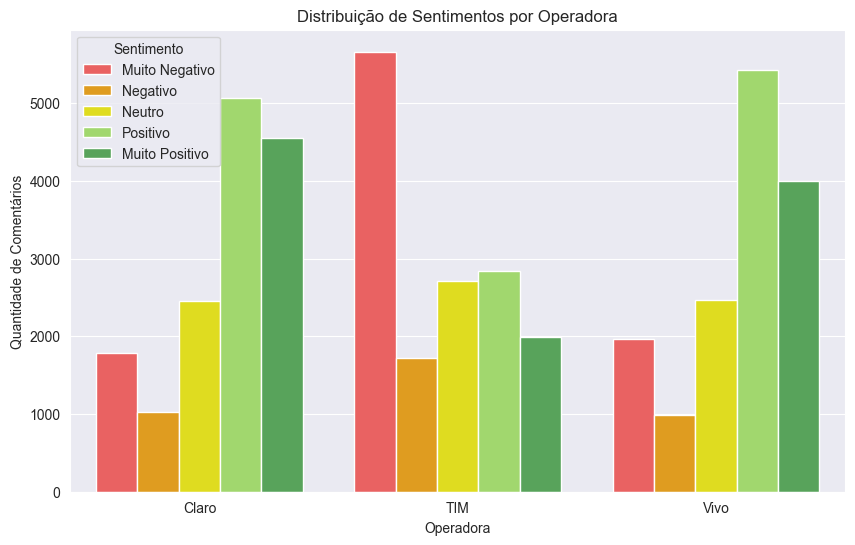

In [44]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.8:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.8:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= 0.7:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

In [45]:
values_claro = df[df['app'] == 'Claro'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_tim = df[df['app'] == 'TIM'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_vivo = df[df['app'] == 'Vivo'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confiança', 'Confusão', 'Neutro']

# Valores de exemplo para cada operadora
values_vivo = values_vivo
values_tim = values_tim
values_claro = values_claro

# Criar subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Gráfico Vivo
fig.add_trace(go.Scatterpolar(
    r=values_vivo,  # Não fechando a linha
    theta=categories,
    fill='toself',
    name='Vivo',
    line=dict(color='royalblue'),
    opacity=0.7
), row=1, col=1)

# Gráfico TIM
fig.add_trace(go.Scatterpolar(
    r=values_tim,
    theta=categories,
    fill='toself',
    name='TIM',
    line=dict(color='firebrick'),
    opacity=0.7
), row=1, col=2)

# Gráfico Claro
fig.add_trace(go.Scatterpolar(
    r=values_claro,
    theta=categories,
    fill='toself',
    name='Claro',
    line=dict(color='darkgreen'),
    opacity=0.7
), row=1, col=3)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="Distribuição de Emoções por Operadora",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False))
)


# Ajuste do posicionamento dos títulos: mais para cima
fig.add_annotation(dict(font=dict(size=16),
                        x=0.13,
                        y=1.1,
                        showarrow=False,
                        text="Vivo",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.1,
                        showarrow=False,
                        text="TIM",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.87,
                        y=1.1,
                        showarrow=False,
                        text="Claro",
                        xref="paper",
                        yref="paper"))

fig.show()


# Classificação de Temas

passar todo o tratamento no NLTK ou outras libs para fazer uma word cloud e saber os principais temas aboradas nos comentários


In [ ]:
# Aplica a função de classificação de temas manuais
df['tema_manual'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais))

# Explode os temas para analisar por linha
df_explodido = df.explode('tema_manual').dropna(subset=['tema_manual'])

# Calcula o sentimento contínuo ponderado
df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

In [75]:
df_claro = df_explodido[df_explodido["app"] == "Claro"]

#Agrupamento por tema
df_tema = df_claro.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale="RdBu",
    range_y=[-1, 1],  # Limite do eixo Y entre -1 e +1
    title="Sentimento Médio Ponderado vs Volume por Tema"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Volume de Comentários",
    yaxis_title="Sentimento Médio Ponderado",
    coloraxis_colorbar=dict(title="Sentimento"),
    template="plotly_white"
)

fig.show()

In [76]:
df_tim = df_explodido[df_explodido["app"] == "TIM"]

#Agrupamento por tema
df_tema = df_tim.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale="RdBu",
    range_y=[-1, 1],  # Limite do eixo Y entre -1 e +1
    title="Sentimento Médio Ponderado vs Volume por Tema"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Volume de Comentários",
    yaxis_title="Sentimento Médio Ponderado",
    coloraxis_colorbar=dict(title="Sentimento"),
    template="plotly_white"
)

fig.show()

In [79]:
df_vivo = df_explodido[df_explodido["app"] == "Vivo"]

#Agrupamento por tema
df_tema = df_vivo.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale="RdBu",
    range_y=[-1, 1],  # Limite do eixo Y entre -1 e +1
    title="Sentimento Médio Ponderado vs Volume por Tema"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Volume de Comentários",
    yaxis_title="Sentimento Médio Ponderado",
    coloraxis_colorbar=dict(title="Sentimento"),
    template="plotly_white"
)

fig.show()

# Próximas Etapas a serem feitas

### Tratamentos
- **OK** - Extração 10k comentários
- **OK** - Apenas comentários de Android
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Ortográfia
- **OK** - Emoji
- **NOTOK** - Abreviações e gírias - Muito complicado para fazer

### Análise Exploratória
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Sentimento Geral por versão
- **OK** - Volume geral por versão do app
- **OK** - Nota média dos comentários por versão
- **NOTOK** - Ironia, classificou tudo como ironia
- **OK** - Os sentimentos como neutros tem a classificação entre 0,3 e 1,0. Não teria como classficar em positivos ou negativos
- **OK** - Separação de positivos e negativos fortes e fracos
- **WIP** - Periodicidade dos comentários para realizar uma análise ao decorrer do tempo de sentimento

### Análise Exploratória
- **WIP** - classificar os temas gerais
- **WIP** - classificar os temas de neutros
- **WIP** - scatterplot vendo o volume de temas
- **WIP** - mapa de wordcloud